# Data Preparing

Firstly, we need to import all the libraries that we need in this program.

In [3]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline 



We use the training set that we downloaded from Kaggle. If more images are needed, we can also download from http://yann.lecun.com/exdb/mnist/ 

In [4]:
# read training data from CSV file
df=pd.read_csv('train.csv')
print('df shape({0[0]},{0[1]})'.format(df.shape))
print(df.head())

df shape(42000,785)
   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8    ...     pixel774  pixel775  pixel776  pixel777  pixel778  \
0       0    ...            0         0         0         0         0   
1       0    ...            0         0         0         0         0   
2       0    ...            0         0         0         0         0   
3       0    ...            0         0         0         0         0   
4       0    ...            0         0         0         0         0   

   pixel779  pixel780  pixel781  pixel782  pixel783  
0         0         0         

Here, we can find that the dataframe shape is 42000*785. It means that we have 42000 examples. In the dataframe, each line represent an example of 28*28=784 pixels. The first column is the label of an example, the others are pixels.

Normalization, use boardcasting to convert from [0:255] => [0.0:1.0]. Normalization can accelerate the speed of our neural network

In [5]:
# normalization, convert from [0:255] => [0.0:1.0]
images = df.iloc[:,1:].values
images = images.astype(np.float)
images = images/255

Then, we want to seperate example number, image width and image height from the whole data set.

In [6]:
# images shape
print('images set shape({0[0]},{0[1]})'.format(images.shape))

image_size = images.shape[1]
print ('image_size => {0}'.format(image_size))

# in this case all images are square
image_width = image_height = np.ceil(np.sqrt(image_size)).astype(np.int)

print ('image_width => {0}\nimage_height => {1}'.format(image_width,image_height))



images set shape(42000,784)
image_size => 784
image_width => 28
image_height => 28


Now we can plot a certain image.

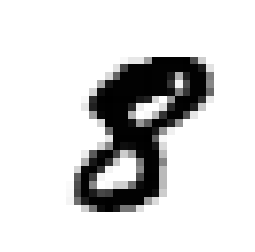

In [7]:
# display image
def display(img):
    
    # (784) => (28,28)
    one_image = img.reshape(image_width,image_height)
    
    plt.axis('off')
    plt.imshow(one_image, cmap='gray_r')

# image number to output
IMAGE_TO_DISPLAY = 10  
# output image   
display(images[IMAGE_TO_DISPLAY])



In [8]:
# get labels 
labels = df[['label']].values

print('labels size({0})'.format(len(labels)))
print ('labels[{0}] => {1}'.format(IMAGE_TO_DISPLAY,labels[IMAGE_TO_DISPLAY]))


labels size(42000)
labels[10] => [8]


The label corresponds to the image.

We should count different tagets to recognize in the dataset. Apparently, the targets are digits from 0 to 9, so the label number should be 10.   

In [9]:
# count different digits
labels_count = np.unique(labels).shape[0]

print('labels_count => {0}'.format(labels_count))

labels_count => 10


Many times in deep learning you will have a y vector with numbers ranging from 0 to C-1, where C is the number of classes. If C is for example 4, then you might have the following y vector which you will need to convert as follows:
![alt text](onehot.png "Title")
This is called a "one hot" encoding, because in the converted representation exactly one element of each column is "hot" (meaning set to 1)

In [10]:
# convert class labels from scalars to one-hot vectors
def one_hot_matrix(labels, C):
    """
    Creates a matrix where the i-th row corresponds to the ith class number and the jth column
                     corresponds to the jth training example. So if example j had a label i. Then entry (i,j) 
                     will be 1. 
                     
    Arguments:
    labels -- vector containing the labels 
    C -- number of classes, the depth of the one hot dimension
    
    Returns: 
    one_hot -- one hot matrix
    """  
    # Create a tf.constant equal to C (depth), name it 'C'. 
    C = tf.constant(C, name = "C")   
    # Use tf.one_hot, be careful with the axis 
    one_hot_matrix = tf.one_hot(labels, C,axis=1) #axis=0 one hot vector is a line, axis=1 one hot vector is a colomn    
    # Create the session 
    sess = tf.Session()
    # Run the session
    one_hot = sess.run(one_hot_matrix, feed_dict = {})
    # Close the session 
    sess.close()
    return one_hot

labels_one_hot = one_hot_matrix(labels.ravel(), labels_count)
labels_one_hot = labels_one_hot.astype(np.int)
print('labels_one_hot({0[0]},{0[1]})'.format(labels_one_hot.shape))
print ('labels[{0}] => {1} => {2}'.format(IMAGE_TO_DISPLAY,labels[IMAGE_TO_DISPLAY],labels_one_hot[IMAGE_TO_DISPLAY]))

labels_one_hot(42000,10)
labels[10] => [8] => [0 0 0 0 0 0 0 0 1 0]


For this dataset of 42000 images that I've got from Kaggle, there is already a test set. So, instead of spliting the whole set into train/dev/test sets, we can just split it into 2 sets, training set and dev set.

In [11]:
# split data into training & dev

# set to 0 to train on all available data
VALIDATION_SIZE = 2000

dev_images = images[:VALIDATION_SIZE]
dev_labels = labels_one_hot[:VALIDATION_SIZE]

train_images = images[VALIDATION_SIZE:]
train_labels = labels_one_hot[VALIDATION_SIZE:]


print('train_images({0[0]},{0[1]})'.format(train_images.shape))
print('train_labels({0[0]},{0[1]})'.format(train_labels.shape))
print('dev_images({0[0]},{0[1]})'.format(dev_images.shape))
print('dev_labels({0[0]},{0[1]})'.format(dev_labels.shape))

train_images(40000,784)
train_labels(40000,10)
dev_images(2000,784)
dev_labels(2000,10)


Now, our data is well prepared for passing to neural network.

# Neural network with Tensorflow

In [31]:
# NN settings
LEARNING_RATE = 1e-4
TRAINING_ITERATIONS = 1000      
DROPOUT = 0.5
BATCH_SIZE = 64

For this NN model, a lot of weights and biases are created. Generally, weights should be initialised with a small amount of noise for symmetry breaking, and to prevent 0 gradients.

Since we are using ReLU neurones (ones that contain rectifier function f(x)=max(0,x)), it is also good practice to initialise them with a slightly positive initial bias to avoid "dead neurones".

In [14]:
# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

For this problem we use zero padded convolutions so that the output is the same size as the input. Stride/step in this case is equal to 1.

In general, convolution layer is used to get the features of the data. In the case of digit recognition - a shape of each digit. It uses learnable kernels/filters each of which corresponds to one particular shape pattern. The number of the filter can differ for other problems.

In [15]:
# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

Pooling is plain max pooling over 2x2 blocks.

Pooling is used for downsampling of the data. 2x2 max-pooling splits the image into square 2-pixel blocks and only keeps maximum value for each of those blocks.

In [16]:
# max pooling 2*2
# [[0,3],
#  [4,2]] => 4

# [[0,1],
#  [1,1]] => 1

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

We'll get back to convolutions and pooling in more detail below.

The good thing about neural networks that any NN can be used as a layer in a large multilayer NN meaning that output of one can be used as input for another. This sequential approach can create very sophisticated NN with multiple layers. They are also called Deep Neural Networks.

In this case, we use two convolution layers with pooling in between them, then densely connected layer followed by dropout and lastly readout layer.

In [17]:
# input & output of NN

# images
x = tf.placeholder('float', shape=[None, image_size])
# labels
y_ = tf.placeholder('float', shape=[None, labels_count])

The first layer is a convolution, followed by max pooling. The convolution computes 32 features for each 5x5 patch. Its weight tensor has a shape of [5, 5, 1, 32]. The first two dimensions are the patch size, the next is the number of input channels (1 means that images are grayscale), and the last is the number of output channels. There is also a bias vector with a component for each output channel.

To apply the layer, we reshape the input data to a 4d tensor, with the first dimension corresponding to the number of images, second and third - to image width and height, and the final dimension - to the number of colour channels.

After the convolution, pooling reduces the size of the output from 28x28 to 14x14.

In [18]:
# first convolutional layer
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

# (40000,784) => (40000,28,28,1)
image = tf.reshape(x, [-1,image_width , image_height,1])
#print (image.get_shape()) # =>(40000,28,28,1)


h_conv1 = tf.nn.relu(conv2d(image, W_conv1) + b_conv1)
#print (h_conv1.get_shape()) # => (40000, 28, 28, 32)
h_pool1 = max_pool_2x2(h_conv1)
#print (h_pool1.get_shape()) # => (40000, 14, 14, 32)


# Prepare for visualization
# display 32 fetures in 4 by 8 grid
layer1 = tf.reshape(h_conv1, (-1, image_height, image_width, 4 ,8))  

# reorder so the channels are in the first dimension, x and y follow.
layer1 = tf.transpose(layer1, (0, 3, 1, 4,2))

layer1 = tf.reshape(layer1, (-1, image_height*4, image_width*8)) 

The second layer has 64 features for each 5x5 patch. Its weight tensor has a shape of [5, 5, 32, 64]. The first two dimensions are the patch size, the next is the number of input channels (32 channels correspond to 32 featured that we got from previous convolutional layer), and the last is the number of output channels. There is also a bias vector with a component for each output channel.
Because the image is down-sampled by pooling to 14x14 size second convolutional layer picks up more general characteristics of the images. Filters cover more space of the picture. Therefore, it is adjusted for more generic features while the first layer finds smaller details.

In [19]:
# second convolutional layer
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
#print (h_conv2.get_shape()) # => (40000, 14,14, 64)
h_pool2 = max_pool_2x2(h_conv2)
#print (h_pool2.get_shape()) # => (40000, 7, 7, 64)

# Prepare for visualization
# display 64 fetures in 4 by 16 grid
layer2 = tf.reshape(h_conv2, (-1, 14, 14, 4 ,16))  

# reorder so the channels are in the first dimension, x and y follow.
layer2 = tf.transpose(layer2, (0, 3, 1, 4,2))

layer2 = tf.reshape(layer2, (-1, 14*4, 14*16)) 

Now that the image size is reduced to 7x7, we add a fully-connected layer with 1024 neurones to allow processing on the entire image (each of the neurons of the fully connected layer is connected to all the activations/outpus of the previous layer)

In [20]:
# densely connected layer
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

# (40000, 7, 7, 64) => (40000, 3136)
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
#print (h_fc1.get_shape()) # => (40000, 1024)

To prevent overfitting, we apply dropout before the readout layer.

Dropout removes some nodes from the network at each training stage. Each of the nodes is either kept in the network with probability keep_prob or dropped with probability 1 - keep_prob. After the training stage is over the nodes are returned to the NN with their original weights.

In [21]:
# dropout
keep_prob = tf.placeholder('float')
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

Finally, we add a softmax layer, the same one if we use just a simple softmax regression.

In [22]:
# readout layer for deep net
W_fc2 = weight_variable([1024, labels_count])
b_fc2 = bias_variable([labels_count])

y = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

#print (y.get_shape()) # => (40000, 10)

To evaluate network performance we use cross-entropy and to minimise it ADAM optimiser is used.

ADAM optimiser is a gradient based optimization algorithm, based on adaptive estimates, it's more sophisticated than steepest gradient descent and is well suited for problems with large data or many parameters.

In [23]:
# cost function
cross_entropy = -tf.reduce_sum(y_*tf.log(y))


# optimisation function
train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(cross_entropy)

# evaluation
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

To predict values from test data, highest probability is picked from "one-hot vector" indicating that chances of an image being one of the digits are highest.

In [24]:
# prediction function
#[0.1, 0.9, 0.2, 0.1, 0.1 0.3, 0.5, 0.1, 0.2, 0.3] => 1
predict = tf.argmax(y,1)

Finally neural network structure is defined and TensorFlow graph is ready for training.

Helper functions
Ideally, we should use all data for every step of the training, but that's expensive. So, instead, we use small "batches" of random data.

This method is called stochastic training. It is cheaper, faster and gives much of the same result.

In [25]:
epochs_completed = 0
index_in_epoch = 0
num_examples = train_images.shape[0]

# serve data by batches
def next_batch(batch_size):
    
    global train_images
    global train_labels
    global index_in_epoch
    global epochs_completed
    
    start = index_in_epoch
    index_in_epoch += batch_size
    
    # when all trainig data have been already used, it is reorder randomly    
    if index_in_epoch > num_examples:
        # finished epoch
        epochs_completed += 1
        # shuffle the data
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        train_images = train_images[perm]
        train_labels = train_labels[perm]
        # start next epoch
        start = 0
        index_in_epoch = batch_size
        assert batch_size <= num_examples
    end = index_in_epoch
    return train_images[start:end], train_labels[start:end]

Now when all operations for every variable are defined in TensorFlow graph all computations will be performed outside Python environment.

In [27]:
# start TensorFlow session
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()

sess.run(init)

Each step of the loop, we get a "batch" of data points from the training set and feed it to the graph to replace the placeholders. In this case, it's: x, y and dropout.

Also, once in a while, we check training accuracy on an upcoming "batch".

On the local environment, we recommend saving training progress, so it can be recovered for further training, debugging or evaluation.

In [30]:
# visualisation variables
train_accuracies = []
validation_accuracies = []
x_range = []

display_step=1

for i in range(TRAINING_ITERATIONS):

    #get new batch
    batch_xs, batch_ys = next_batch(BATCH_SIZE)        

    # check progress on every 1st,2nd,...,10th,20th,...,100th... step
    if i%display_step == 0 or (i+1) == TRAINING_ITERATIONS:
        
        train_accuracy = accuracy.eval(feed_dict={x:batch_xs, 
                                                  y_: batch_ys, 
                                                  keep_prob: 1.0})       
        if(VALIDATION_SIZE):
            validation_accuracy = accuracy.eval(feed_dict={ x: dev_images[0:BATCH_SIZE], 
                                                            y_: dev_labels[0:BATCH_SIZE], 
                                                            keep_prob: 1.0})                                  
            print('training_accuracy / validation_accuracy => %.2f / %.2f for step %d'%(train_accuracy, validation_accuracy, i))
            
            validation_accuracies.append(validation_accuracy)
            
        else:
             print('training_accuracy => %.4f for step %d'%(train_accuracy, i))
        train_accuracies.append(train_accuracy)
        x_range.append(i)
        
        # increase display_step
        if i%(display_step*10) == 0 and i:
            display_step *= 10
    # train on batch
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys, keep_prob: DROPOUT})

training_accuracy / validation_accuracy => 1.00 / 1.00 for step 0
training_accuracy / validation_accuracy => 0.98 / 1.00 for step 1
training_accuracy / validation_accuracy => 1.00 / 1.00 for step 2
training_accuracy / validation_accuracy => 1.00 / 1.00 for step 3
training_accuracy / validation_accuracy => 1.00 / 1.00 for step 4
training_accuracy / validation_accuracy => 1.00 / 1.00 for step 5
training_accuracy / validation_accuracy => 1.00 / 1.00 for step 6
training_accuracy / validation_accuracy => 1.00 / 1.00 for step 7
training_accuracy / validation_accuracy => 1.00 / 1.00 for step 8
training_accuracy / validation_accuracy => 0.98 / 1.00 for step 9
training_accuracy / validation_accuracy => 1.00 / 1.00 for step 10
training_accuracy / validation_accuracy => 0.98 / 1.00 for step 20
training_accuracy / validation_accuracy => 0.98 / 0.98 for step 30
training_accuracy / validation_accuracy => 1.00 / 1.00 for step 40
training_accuracy / validation_accuracy => 1.00 / 1.00 for step 50
train

KeyboardInterrupt: 

After training is done, it's good to check accuracy on data that wasn't used in training.

validation_accuracy => 0.9920


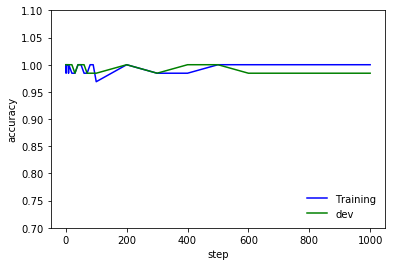

In [32]:
# check final accuracy on dev set  
if(VALIDATION_SIZE):
    validation_accuracy = accuracy.eval(feed_dict={x: dev_images, 
                                                   y_: dev_labels, 
                                                   keep_prob: 1.0})
    print('validation_accuracy => %.4f'%validation_accuracy)
    plt.plot(x_range, train_accuracies,'-b', label='Training')
    plt.plot(x_range, validation_accuracies,'-g', label='dev')
    plt.legend(loc='lower right', frameon=False)
    plt.ylim(ymax = 1.1, ymin = 0.7)
    plt.ylabel('accuracy')
    plt.xlabel('step')
    plt.show()

When, we're happy with the outcome, we read test data from test.csv and predict labels for provided images.

Test data contains only images and labels are missing. Otherwise, the structure is similar to training data.

Predicted labels are stored into CSV file for future submission.

test_images(28000,784)
predicted_lables(28000)
predicted_lables[10] => 5.0


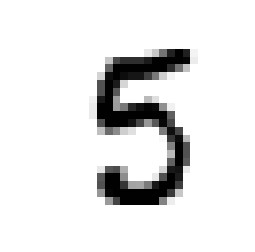

In [33]:
# read test data from CSV file 
test_images = pd.read_csv('test.csv').values
test_images = test_images.astype(np.float)

# convert from [0:255] => [0.0:1.0]
test_images = np.multiply(test_images, 1.0 / 255.0)

print('test_images({0[0]},{0[1]})'.format(test_images.shape))


# predict test set
#predicted_lables = predict.eval(feed_dict={x: test_images, keep_prob: 1.0})

# using batches is more resource efficient
predicted_lables = np.zeros(test_images.shape[0])
for i in range(0,test_images.shape[0]//BATCH_SIZE):
    predicted_lables[i*BATCH_SIZE : (i+1)*BATCH_SIZE] = predict.eval(feed_dict={x: test_images[i*BATCH_SIZE : (i+1)*BATCH_SIZE], 
                                                                                keep_prob: 1.0})


print('predicted_lables({0})'.format(len(predicted_lables)))

# output test image and prediction
display(test_images[IMAGE_TO_DISPLAY])
print ('predicted_lables[{0}] => {1}'.format(IMAGE_TO_DISPLAY,predicted_lables[IMAGE_TO_DISPLAY]))

# save results
np.savetxt('submission_softmax.csv', 
           np.c_[range(1,len(test_images)+1),predicted_lables], 
           delimiter=',', 
           header = 'ImageId,Label', 
           comments = '', 
           fmt='%d')

As it was mentioned before, it is good to output some variables for a better understanding of the process.

Here we pull an output of the first convolution layer from TensorFlow graph. 32 features are transformed into an image grid, and it's quite interesting to see how filters picked by NN outline characteristics of different digits.

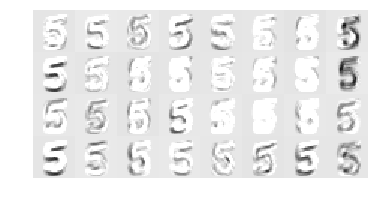

In [35]:
layer1_grid = layer1.eval(feed_dict={x: test_images[IMAGE_TO_DISPLAY:IMAGE_TO_DISPLAY+1], keep_prob: 1.0})
plt.axis('off')
plt.imshow(layer1_grid[0], cmap='gray_r' )


In [ ]:
sess.close()

References: 
[1].Andrew Ng's Deep Learning Specialization on the Coursera
[2].Kirill Kliavin's tutotial "TensorFlow deep NN" on the Kaggle
